In [77]:
import json
import pandas as pd
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Question 1: Choose a method of accessing the data in the data zip file

### 1.1. Accessing airplane_details.json

In [78]:

#Because the json file is not in a valid form, it does not have:
# - Comma to seperate list of key-value pairs (,).
# - Enclosed by a pair of square brackets [...].

#Loops through each line in the file, considered it as a valid Json object and add each of them into a list

airplanes = []
with open('D:/Rotate/data/airplane_details.json', 'r') as file:
    for line in file:
            airplanes.append(json.loads(line))

print(airplanes)


[{'code_iata': '388', 'code_icao': 'A388', 'full_name': 'Airbus A380-800', 'category': 'A380', 'average_speed_mph': 550.0, 'volume': 86.74944, 'payload': 83417.6077}, {'code_iata': '351', 'code_icao': 'A35K', 'full_name': 'Airbus A350-1000', 'category': 'A350', 'average_speed_mph': 558.0, 'volume': 120.12864, 'payload': 66242.9}, {'code_iata': '788', 'code_icao': 'B788', 'full_name': 'Boeing B787-8', 'category': 'B787', 'average_speed_mph': 570.0, 'volume': 74.784, 'payload': 40610.8525}, {'code_iata': 'M82', 'code_icao': 'MD82', 'full_name': 'Boeing MD80-82', 'category': 'MD80', 'average_speed_mph': 461.0, 'volume': 9.85872, 'payload': 17989.3965}, {'code_iata': 'AR8', 'code_icao': 'RJ85', 'full_name': 'Avro RJ85', 'category': 'RJ', 'average_speed_mph': 368.0, 'volume': 3.9216, 'payload': 12136.2925}, {'code_iata': '789', 'code_icao': 'B789', 'full_name': 'Boeing B787-9', 'category': 'B787', 'average_speed_mph': 570.0, 'volume': 99.19824, 'payload': 51991.7782}, {'code_iata': '343', '

In [79]:
airplanes = pd.DataFrame(airplanes)

### 1.2. Acccessing flight_events

In [80]:
import pandas as pd
import glob

# Get a list of all CSV files in a directory
csv_files = glob.glob('D:/Rotate/data/flight_events/*.csv')

# Create an empty dataframe to store the combined data
combined_df = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file, sep=";")
    combined_df = pd.concat([combined_df, df])

In [81]:
flight_events = pd.DataFrame(combined_df)

## Question 2

### 2.1.Checking dataset 

In [82]:
airplanes.dtypes

code_iata             object
code_icao             object
full_name             object
category              object
average_speed_mph    float64
volume               float64
payload              float64
dtype: object

In [83]:
flight_events.dtypes

address              object
altitude              int64
callsign             object
date                 object
destination_iata     object
destination_icao     object
equipment            object
event                object
flight               object
flight_id             int64
latitude            float64
longitude           float64
operator             object
origin_iata          object
origin_icao          object
registration         object
time                 object
dtype: object

In [84]:
airplanes.shape

(100, 7)

In [85]:
flight_events.shape

(700000, 17)

In [86]:
airplanes.isna().sum()

code_iata             0
code_icao             0
full_name             0
category              1
average_speed_mph     0
volume               43
payload               0
dtype: int64

In [87]:
flight_events.isna().sum()

address                  0
altitude                 0
callsign             11077
date                     0
destination_iata     41700
destination_icao     41460
equipment             6410
event                    0
flight              149577
flight_id                0
latitude                 0
longitude                0
operator            133095
origin_iata          41930
origin_icao          40878
registration          5248
time                     0
dtype: int64

### 2.2. Merging 2 tables 

In [88]:
capacity = pd.merge(flight_events, airplanes, left_on="equipment", right_on="code_icao", how="inner")

In [89]:
#Create routes column from origin_iata and destination iata
capacity["routes"]= capacity["origin_iata"] + "-" + capacity["destination_iata"]

In [90]:
#Because one flight can have multiple events, therefore, we only considered unique values of flights
capacity2 = capacity[["routes", "volume", "payload", "flight_id"]].drop_duplicates()

In [91]:
final_capacity = (
    capacity2.groupby("routes", as_index=True)
    .aggregate({"routes": "count", "volume": "sum", "payload": "sum"})
    .rename(columns={
        "routes": "number_of_flight",
        "volume": "total_volume",
        "payload": "total_weight"
    })
).reset_index()

In [92]:
final_capacity

,routes,number_of_flight,total_volume,total_weight
0,AAE-IST,1,14.03568,21078.0953
1,AAE-MED,1,14.03568,21078.0953
2,AAL-CPH,1,14.03568,21078.0953
3,AAN-PEW,2,28.43616,38559.3000
4,AAP-CGK,7,98.24976,147546.6671
...,...,...,...,...
16083,ZYI-NKG,1,8.10768,17302.2500
16084,ZYI-WNZ,1,14.03568,21078.0953
16085,ZYI-ZUH,2,28.43616,38559.3000
16086,ZYL-DAC,1,14.03568,21078.0953


### 2.3. Investigation on non-matching flights

#### Explaination
In step 2.2, I observed that only **106,162** flights could be identified for cargo capacity out of a total of **202,407** flights. The discrepancy arises due to the limitations in the data between two tables:

- Airplanes Table (DIM Table): This table contains data for **100** airplanes information
- Event Flight Table (FACT Table): This table records flight events over a 7-day period (from 03/10/2022 to 09/10/2022) and includes data for **682** airplanes that were used during these flights.

=>  There may be airplanes used in the flights that are not present in the airplanes DIM table. These airplanes are missing from the table, resulting in gaps in the cargo capacity data for those flights.

In [93]:
capacity["flight_id"].nunique() #The number of flights can identify cargo capacity
flight_events["flight_id"].nunique() #The number of flights we have
flight_events["equipment"].nunique() ##The number of airplanes had been used
airplanes.shape #The number of airplanes that we have information

(100, 7)

Solution 1: Flag flights with missing airplane information. These flights could be excluded from final cargo capacity calculations or treated as a special case, where either make an estimation or leave them out if estimations are not reliable.

In [94]:
missing_airplane_info_flights= flight_events[~flight_events["flight_id"].isin(capacity["flight_id"])]

Solution 2: Create a list to identify which airplanes are missing in the DIM table and attempt to match them with other data sources 

In [95]:
missing_airplane_info = missing_airplane_info_flights["equipment"].drop_duplicates()

## Question 3

#### Project 1: Dashboard in Looker Studio

In [96]:
capacity["datetime"] = capacity["date"] + " " + capacity["time"] #create datetime variables 

In [97]:
capacity["datetime"]= pd.to_datetime(capacity["datetime"]) #Convert to datetime form in pandas
capacity["date"]= pd.to_datetime(capacity["date"]) #Convert to datet form in pandas

In [98]:
dashboard_data = capacity.loc[capacity.groupby('flight_id')['datetime'].idxmax()] #Select the most current situation of each flight

In [99]:
#dashboard_data.to_csv("dashboard_data.csv",index=False)

View the dashboard provided in the following link : https://lookerstudio.google.com/reporting/8e425773-ffa4-4bc9-a8b9-3f080b352d82

#### Projecr 2: Model to predict number of flights in each route


In [100]:
#Create a new variable:  day_of_week variable
dashboard_data["day_of_week"] = dashboard_data["datetime"].dt.day_of_week

In [101]:
#Select informative columns for model 
df_model = dashboard_data[["date","flight_id","routes", "day_of_week","equipment","operator", "average_speed_mph", "payload", "volume"]]

In [103]:
#Handle missing values
df_model.isna().sum()
df_model = df_model.dropna()

In [106]:
#Create a dataset for modelling, where each row represents the detailed information for a specific route (departure and arrival airports) on a given day.

df_model = (dashboard_data.groupby(["routes","date", "day_of_week","equipment","operator","category" ,"average_speed_mph"])
    .aggregate({"volume":"sum", "payload":"sum", "flight_id":"count"})
    .rename(columns= {"flight_id":"number_of_flights"})
    ) 
df_model = pd.DataFrame(df_model.reset_index())

In [107]:
X = df_model.drop(columns=["date","number_of_flights" ]) # Drop date as they are not useful for modeling
y = df_model["number_of_flights"] 

In [108]:
import catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib

In [119]:
#Train_test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
#Because the dataset is too large to train, I decided to train in a smaller sample

In [120]:
y_train

43307    2
70769    1
25373    2
72526    1
63595    1
        ..
25324    1
65689    1
87796    1
33634    1
47280    1
Name: number_of_flights, Length: 73500, dtype: int64

In [121]:
x_train

,routes,day_of_week,equipment,operator,category,average_speed_mph,volume,payload
43307,JED-CAI,6,A333,SVA,A330,558.0,172.00320,88983.0000
70769,PVG-BKK,6,B77L,UAE,B777,562.0,86.27520,63233.2972
25373,DFW-STL,2,B738,AAL,B737,592.0,28.07136,42156.1906
72526,ROB-BRU,0,A333,BEL,A330,558.0,86.00160,44491.5000
63595,OGG-SJC,0,B738,ASA,B737,592.0,14.03568,21078.0953
...,...,...,...,...,...,...,...,...
25324,DFW-SFO,4,A319,UAL,A319,514.0,8.10768,17302.2500
65689,ORD-VIE,3,B772,AUA,B777,562.0,86.27520,54299.4040
87796,WNZ-TYN,3,A320,CCA,A320,521.0,14.21808,19279.6500
33634,GRU-JFK,0,B772,AAL,B777,562.0,86.27520,54299.4040


In [122]:
# CatBoost model
model = catboost.CatBoostRegressor(cat_features=['routes', 'equipment','operator','category'])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'iterations': [1000],
    'learning_rate': [0.1, 0.2, 0.3],
    'depth': [2,4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Fit the model and tune the hyperparameters
grid_search.fit(x_train, y_train)

In [115]:
df_tunning_results = pd.DataFrame(grid_search.cv_results_) #Save the result of tunning hyperparameters

In [116]:
best_model = grid_search.best_estimator_ #get the best model 
#joblib.dump(best_model, 'catboost.pkl') #save model for later

In [46]:
#best_model =  joblib.load('catboost.pkl') #Load the best model

In [117]:
#testing the results
y_pred = best_model.predict(x_test)
y_pred = [int(i) for i in y_pred] #Convert the predicted number of flights to int
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.4905


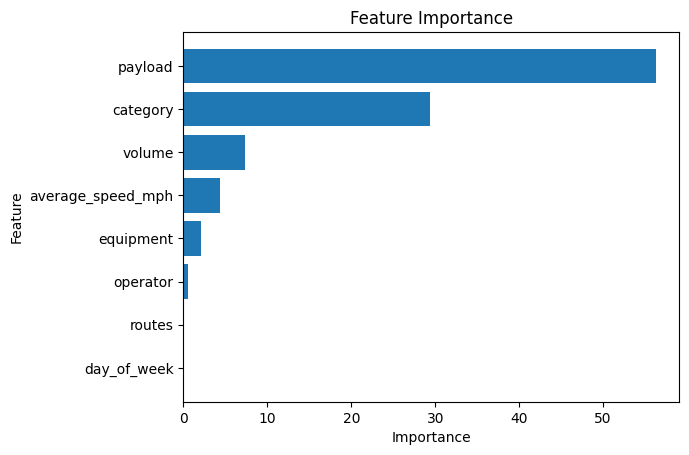

In [118]:
#Check the feature importancce

# Convert feature importance to a DataFrame
importance_df = pd.DataFrame({
    'Feature': x_test.columns,
    'Importance': best_model.get_feature_importance()
})

# Plot feature importance
importance_df.sort_values(by="Importance", ascending=False, inplace=True)
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Reverse the order for a better look
plt.show()
